In [2]:
import math
import random
import numpy as np
import pandas as pd

In [3]:
seedcount = 42

In [4]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
# 	torch.manual_seed(seed)
# 	torch.cuda.manual_seed(seed)
# 	torch.cuda.manual_seed_all(seed)
# 	torch.backends.cudnn.benchmark = False
# 	torch.backends.cudnn.deterministic = True
    
seed_everything(seedcount)
seedcount+=1

### Skew@k

In [4]:
def skewk(rankedlist, prob, attr, k): 
    count = 0
    epsilon = 0.000001
    for item in rankedlist[:k]:
        if item['real_attr']==attr:
            count+=1
    frac_ranked = count/k
    countall = 0
#     for item in rankedlist:
#         if item['attr']==attr:
#             countall+=1
    frac_real = prob[attr]
    return (frac_ranked+epsilon)/(frac_real+epsilon) #Removed math.log

### NDKL

In [5]:
def KL(p, q):
    """ Computes Kullback-Leibler divergence between two distributions.
    Both p and q must be dictionaries from events to probabilities.
    The divergence is defined only when q[event] == 0 implies p[event] == 0.
    """
    KL = 0
    epsilon = 1e-10
    for i in p:
        if p[i]>0:
            KL+= p[i] * math.log((p[i]+epsilon)/(q[i]+epsilon))
        else:
            KL+=0
    return KL

In [6]:
def NDKL(tau,q):
    Z = sum(1/math.log2(i+1) for i in range(1,len(tau)+1))
    DKL = 0
    #q = getdist(tau)
    for k in range(1,len(tau)+1):
        p = getdist(tau[:k])
        DKL+= (1/math.log2(k+1))*KL(p,q)
    return DKL/Z

### NDCG

In [7]:
def DCG(R, k, method=0):
    r = [i['score'] for i in R]
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def NDCG(r, k, method=0):
    dcg_max = DCG(sorted(r, key = lambda i: i['score'],reverse=True), k, method)
    if not dcg_max:
        return 0.
    return DCG(r, k, method) / dcg_max

In [8]:
def getdist(p):  
    # Given a list, return the protected attr dist as a dictionary 
    d = {}
    for person in p:
        if person['real_attr'] not in d:
            d[person['real_attr']]=1
        else:
            d[person['real_attr']]+=1
    for attr in d:
        d[attr] = d[attr]/len(p)
    return d

In [9]:
def getdist_mispredicted(p):  
    # Given a list, return the protected attr dist as a dictionary 
    d = {}
    for person in p:
        if person['attr'] not in d:
            d[person['attr']]=1
        else:
            d[person['attr']]+=1
    for attr in d:
        d[attr] = d[attr]/len(p)
    return d

In [5]:
# Compute Attention Function for the different attributes
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
# #     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
# #     'text.usetex': True,
#     'pgf.rcfonts': False
# })

# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })


import seaborn as sns
sns.set_style('darkgrid')


def getskews(rankedlist,prob):
    skew_dic = {}
    #countdict = {}
    atts = set([])
    for item in rankedlist:
        atts.add(item['real_attr'])# attr
    
    for attr in atts:
        skew_dic[attr] = skewk(rankedlist,prob,attr,len(rankedlist))

    return skew_dic
    
def get_score(rankedlist): # attr -> real_attr
    score_dic = {}
    #countdict = {}
    for item in rankedlist:

        if item['real_attr']+'_list' not in score_dic:
            score_dic[item['real_attr']+'_list'] = []
        #if item['attr'] not in countdict:
            #countdict[item['attr']] = 0
        score_dic[item['real_attr']+'_list'].append(item['score'])
        #countdict[item['attr']] +=1
        
    score_dic2 = {}
        
    for attl in score_dic:
        attr = attl[:-5]
        score_dic2[attr] = np.mean(score_dic[attl])
        #print(attl)
        #print(sorted(score_dic[attl]))

#     X= sorted(att_dic.keys())
#     g = sns.barplot(x=X,y=[att_dic[i] for i in X])
#     g.set_yscale("log", basey=10)
#     plt.xticks(rotation=75)
#     plt.show()
    
    return score_dic2


def get_attention(rankedlist, dist = 'log', p = -1):
    sns.set(font_scale=1.5)
    base_attention = 100
    i = 1
    att_dic = {}
    #countdict = {}
    for item in rankedlist:
        if dist == 'log':
            attention = base_attention/math.log2(i+1)
        elif dist == 'geometric':
            if p== -1:
                print('Error, set p = fraction of attention for the first result')
                return
            else:
                attention = base_attention*((1 - p)**(i-1))*p
        else:
            print('Error, dist must be log or geometric')

        if item['real_attr']+'_list'  not in att_dic:
            att_dic[item['real_attr']+'_list'] = []
#         if item['attr'] not in countdict:
#             countdict[item['attr']] = 0
        att_dic[item['real_attr']+'_list'].append(attention)
#         countdict[item['attr']] +=1
        i+=1
    
    
    att_dic2 = {}                                      
   
    for attl in att_dic:
        attr = attl[:-5]
        if dist == 'geometric':
            att_dic2[attr] = np.mean(att_dic[attl])
        else:
            att_dic2[attr] = np.mean(att_dic[attl])
            #print(attl)
            #print(sorted(att_dic[attl]))


#     X= sorted(att_dic2.keys())
#     g = sns.barplot(x=X,y=[att_dic2[i] for i in X])
#     if dist == 'geometric':
#         g.set_yscale("log", basey=10)
#     plt.xticks(rotation=75)
#     plt.show()
    
    return att_dic2

def get_di(rankedlist, dist = 'log', p = -1): # attr -> real_attr
    base_attention = 100
    i = 1
    att_dic = {}
    #countdict = {}
    for item in rankedlist:
        if dist == 'log':
            attention = base_attention/math.log2(i+1)
        elif dist == 'geometric':
            if p== -1:
                print('Error, set p = fraction of attention for the first result')
                return
            else:
                attention = base_attention*((1 - p)**(i-1))*p
        else:
            print('Error, dist must be log or geometric')

        if item['real_attr']+'_list' not in att_dic:
            att_dic[item['real_attr']+'_list'] = []
        #if item['attr'] not in countdict:
            #countdict[item['attr']] = 0
        att_dic[item['real_attr']+'_list'].append(attention*item['score'])
        #countdict[item['attr']] +=1
        i+=1
        
    att_dic2 = {}                                      
    for attl in att_dic:
        attr = attl[:-5]
        att_dic2[attr] = np.mean(att_dic[attl])
    
    return att_dic2



def getheatmap(dict1, dict2, name1, name2):
    sns.set(font_scale=0.9)
    l = []
    for i in sorted(dict1):
        k = {}
        for j in sorted(dict2):
            if i == j:
                k[j] = dict1[i]-dict2[j]
            else:
                k[j] = (dict1[i]-dict1[j])-(dict1[i]-dict2[j])
        k['name']=i
        l.append(k)
    df = pd.DataFrame(l)
    df.set_index('name',inplace=True, drop=True)
    mask_ut=np.triu(np.ones(df.shape)).astype(np.bool)
    mask_ut[np.diag_indices_from(mask_ut)] = False
    ax = sns.heatmap(df,annot=True)
#     ax = sns.heatmap(df,mask=mask_ut,annot=True)
    ax.set(xlabel=name2, ylabel=name1)
    plt.show()
    return df

In [11]:
def showmetrics(rankedlist,prob):
    ndkl = NDKL(rankedlist,prob)
    attd = get_attention(rankedlist)
    skewd = getskews(rankedlist,prob)
    scoredic = get_score(rankedlist)
    geoattd = get_attention(rankedlist,dist='geometric',p=0.015)
        
    DI = get_di(rankedlist,dist='geometric',p=0.015)
    
    attd = geoattd
    
    print('NDKL of this ranking: ',ndkl)
    print('Skew Measure: ',skewd)
    vals = skewd.values()
    print("\t mean skew :", np.mean(list(vals)))
    print("\t Standard deviation of skew :", np.std(list(vals)))
    print("\t Skew bias ratio: ", min(vals)/max(vals))

    vals = attd.values()
#     print('Group fairness metrics\n\n')
    print('Groupwise Exposure: ', attd)
    print("\t mean exposure :", np.mean(list(vals)))
    print("\t Standard deviation of exposure :", np.std(list(vals)))
    print("\t Exposure bias ratio: ", min(vals)/max(vals))

    
    DT = {}
    for k in attd:
        DT[k]=attd[k]/scoredic[k]
    
    vals = DT.values()
    print('Disparate Treatment Metric')
    print('Group exposure/utility: ',DT)
    print("\t mean exposure/utility :", np.mean(list(vals)))
    print("\t Standard deviation of exposure/utility :", np.std(list(vals)))
    print('\t Disparate Treatment Min Bias Ratio: ',min(vals)/max(vals))
    
#     print('Individual fairness metric \n\n')
    print('Disparate Impact Metric')

    
    print('Group exposure_i*utility_i: ',DI)
    vals = DI.values()
    print("\t mean exposure_i*utility_i :", np.mean(list(vals)))
    print("\t Standard deviation of exposure_i*utility_i :", np.std(list(vals)))
    print('\t Disparate Impact Min Bias Ratio: ',min(vals)/max(vals))
    
    return ndkl,attd,DI,DT,skewd,geoattd


## Shuffle

In [12]:
#samplepred

In [13]:
# print(samplepred)

from numpy.random import choice


def misinterpret(oglist, ethaccdict, method_name):
    #attrs = set([i['real_attr'] for i in oglist])
    newlist = []

    if method_name!='DeepFace':
        oc = Counter([item['real_attr'].split('_')[0] for item in oglist])
        cd = {}

        for c in oc:
            if c != 'Other':
                list_of_candidates = list(oc.keys())
                raw_p = [float(ethaccdict[c][i]) for i in list_of_candidates]
                probability_distribution = [i/sum(raw_p) for i in raw_p]
                cd[c] = list(choice(list_of_candidates, oc[c], p=probability_distribution))
        for item in oglist:
            ograce = item['real_attr'].split('_')[0]
            if ograce != 'Other':
                oggen = item['real_attr'].split('_')[1]
                item['attr']=str(cd[ograce].pop()) +'_'+oggen
                newlist.append(item)
    else:
        oc = Counter([item['real_attr'] for item in oglist])
        cd = {}
        for c in oc:
            if c.split('_')[0] != 'Other':
                list_of_candidates = list(oc.keys())
                raw_p = [float(ethaccdict[c][i]) for i in list_of_candidates]
                probability_distribution = [i/sum(raw_p) for i in raw_p]
                cd[c] = list(choice(list_of_candidates, oc[c], p=probability_distribution))
        for item in oglist:
            ograce = item['real_attr'].split('_')[0]
            if ograce != 'Other':
#                 oggen = item['real_attr'].split('_')[1]
                item['attr']=str(cd[item['real_attr']].pop())
                newlist.append(item)
    return newlist

### Detgreedy, DetCons, DetRelaxed implementation

In [14]:
# attributes are set as a list attr_list
import operator
import math

def rev_dict(d, reverse_flag = True):
    return sorted(d.items(),key=operator.itemgetter(1),reverse=reverse_flag)


def det_algo(score_dict, algo_type, prob, kmax):
    scoreList = [(elem['attr'], elem['score'], elem['real_attr']) for elem in score_dict]
#     print(score_dict)
    
    rankedAttList   = []
    rankedScoreList = []
    rankedRealAttrList = []
    AttrList        = list(set([elem[0] for elem in scoreList]))
    AttrCounts      = {}
    GlobalAttrProb  = prob
    AttrScores      = {}
    GlobalAttrCounts = {}
    RealAttrLocs     = {}
    
    newrankedList = []
    
    KMAX = kmax

    for i, attr in enumerate(AttrList):
        AttrCounts[attr]=0
        #GlobalAttrProb[attr] = sum([1 for elem in scoreList if elem[0]==attr])/len(scoreList)
        GlobalAttrCounts[attr]= sum([1 for elem in scoreList if elem[0]==attr])
        AttrScores[attr] = [elem[1] for elem in scoreList if elem[0]==attr] # to be initialized 
        RealAttrLocs[attr]= [elem[2] for elem in scoreList if elem[0]==attr] # to be initialized 
        
    for k in range(0, KMAX):
        belowMin = {}
        belowMax = {}
        belowMaxNorm = {}
        belowMaxNormSet = {}
        belowMinFlag= False
    
        for attr in AttrList:
            if AttrCounts[attr] < math.floor(GlobalAttrProb[attr]*k):
                belowMin[attr] = AttrScores[attr][AttrCounts[attr]]
                belowMinFlag = True
            elif AttrCounts[attr] <= math.ceil(GlobalAttrProb[attr]*k) and AttrCounts[attr]< GlobalAttrCounts[attr]:
                try:
                    belowMax[attr]        = AttrScores[attr][AttrCounts[attr]]
                    belowMaxNorm[attr]    = math.ceil(GlobalAttrProb[attr]*k)/GlobalAttrProb[attr]
                    belowMaxNormSet[attr] = math.ceil(math.ceil(GlobalAttrProb[attr]*k)/GlobalAttrProb[attr])
                except Exception as e:
                    import pdb; pdb.set_trace()

#         print(k, belowMin, belowMax)
        nextAttr = None
    
        if belowMinFlag:
            nextAttr = rev_dict(belowMin)[0][0]
#             nextScore = rev_dict(belowMin)[0][1]
#             print(nextAttr, nextScore, AttrScores[nextAttr][AttrCounts[nextAttr]])
#             nextRealAttr = rev_dict()
        else:
            if algo_type=='DetGreedy':            
                sorted_dict = rev_dict(belowMax)
                nextAttr    = sorted_dict[0][0]
#                 nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
            elif algo_type =='DetCons':
                sorted_dict = rev_dict(belowMaxNorm, False)
                nextAttr    = sorted_dict[0][0]
#                 nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
            elif algo_type =='DetRelaxed':
                sorted_dict = rev_dict(belowMaxNormSet, False)
                min_attr_set = [elem[0] for elem in sorted_dict if elem[1]==sorted_dict[0][1]]
                prunebelowMax = {}
                for elem in belowMax:
                    if elem in min_attr_set:
                        prunebelowMax[elem]=belowMax[elem]
                sorted_dict2 = rev_dict(prunebelowMax)
                nextAttr    = sorted_dict2[0][0]
#                 nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
#                 nextRealAttr = RealAttrLocs[nextAttr][AttrCounts[nextAttr]]
    
        nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
        nextRealAttr = RealAttrLocs[nextAttr][AttrCounts[nextAttr]]
        rankedAttList.append(nextAttr)
        rankedScoreList.append(nextScore)
        rankedRealAttrList.append(nextRealAttr)
        
        newrankedList.append({'attr':nextAttr,'score':nextScore, 'real_attr': nextRealAttr})
        AttrCounts[nextAttr]+=1
        
    return newrankedList

In [15]:
a = {'a':(1,2), 'b':(5,3), 'c':(2,7)}
print(sorted(a.items(), key= lambda x: x[1][0], reverse= True))

[('b', (5, 3)), ('c', (2, 7)), ('a', (1, 2))]


# DetConsSorted Implementation

In [16]:
from collections import defaultdict as ddict
import operator


def swap(temp_list, pos_i, pos_j):
    temp = temp_list[pos_i]
    temp_list[pos_i] = temp_list[pos_j]
    temp_list[pos_j] = temp

def det_const_sort(score_dict, prob, kmax):
    
    scoreList             = [(elem['attr'], elem['score'], \
                        elem['real_attr']) for elem in score_dict]
    AttrList              = list(set([elem[0] for elem in scoreList]))
    AttrScores            = {}
    AttrCount             = {}
    minAttrCount          = {}
    GlobalAttrCounts      = {}
    rankedAttrList        = {} #[]
    rankedScoreList       = {} #[]
    maxIndices            = {} #[]
    lastEmpty             =  0
    k                     =  0
    
    for i, attr in enumerate(AttrList):
        AttrCount[attr]        = 0
        minAttrCount[attr]     = 0
        GlobalAttrCounts[attr] = sum([1 for elem in scoreList if elem[0]==attr])
        AttrScores[attr]       = [(elem[1],elem[2]) for elem in scoreList if elem[0]==attr] # to be initialized 
        
    while lastEmpty       <= kmax:        
        
        if lastEmpty == len(scoreList):
            break
        
        k+=1
        tempMinAttrCount  = ddict(int)
        changedMins       = {}
        for attr in AttrList:
            tempMinAttrCount[attr] = math.floor(k*prob[attr])
            if minAttrCount[attr] < tempMinAttrCount[attr] and minAttrCount[attr] < GlobalAttrCounts[attr]:
                changedMins[attr]  = AttrScores[attr][AttrCount[attr]]
                    
        if len(changedMins) !=0:
            ordChangedMins  = sorted(changedMins.items(), key= lambda x: x[1][0], reverse= True)
            for elem in ordChangedMins:
                rankedAttrList[lastEmpty] = elem[0]
                rankedScoreList[lastEmpty]= AttrScores[elem[0]][AttrCount[elem[0]]] # (score, real_attr)
                maxIndices[lastEmpty]     = k
                start                     = lastEmpty
                while start > 0 and maxIndices[start-1] >= start and rankedScoreList[start-1][0]< rankedScoreList[start][0]:                
                    swap(rankedScoreList, start-1, start)
                    swap(maxIndices, start-1, start)
                    swap(rankedAttrList, start-1, start)
                    start -= 1
                AttrCount[elem[0]]+=1
                lastEmpty+=1
            minAttrCount= dict(tempMinAttrCount)
        
    
    newRankList = []
    
    rankedAttrArr  = [rankedAttrList[i] for i in sorted(rankedAttrList)]
    rankedScoreArr = [rankedScoreList[i] for i in sorted(rankedScoreList)]
    for attr, score in zip(rankedAttrArr, rankedScoreArr ):
        newRankList.append({'attr':attr, 'score':score[0], 'real_attr': score[1]})
        
    return newRankList

In [17]:
# K = len(incomerank_og)
# incomedetconsort_og = det_const_sort(incomerank_og,incomedist,K)
# incomedetconsort_shuff_dict = det_const_sort(incomerank_shuffled_dict,incomedist,K)
# incomedetconsort_shuff_ethncolor = det_const_sort(incomerank_shuffled_ethncolor,incomedist,K)
# incomedetconsort_shuff_cnn = det_const_sort(incomerank_shuffled_cnn,incomedist,K)

### Simulation

In [18]:
#simulate_err({"White":0.33,"Black":0.33,"Asian":0.33})

In [19]:
def genprob(attrlist):
    prob = {}
    s = 0
    for attr in attrlist:
        p = np.random.uniform(0,1)
        s+=p
        prob[attr]=p
    for attr in attrlist:
        prob[attr]/=s
    return prob

In [20]:
def getcandidates(prob):
    elements = list(prob.keys())
    candidates = []
    for e in elements:
        for n in range(1000):#(int(k/len(elements))):
            candidates.append(e)
    clist = []
    idn = 1
    for c in candidates:
        cand = {}
        cand['id']= str(idn)
        idn+=1
        cand['attr']= c
        cand['real_attr']= c
        cand['score']=np.random.uniform(0,1)
        clist.append(cand)
    clist.sort(key = lambda i: i['score'],reverse=True)
    return clist

In [21]:
def randomize(oglist, acc):
    attrs = set([i['real_attr'] for i in oglist])
    newlist = []
    for item in oglist:
        if random.random() < acc: #True
            item['attr']=item['real_attr']
        else:
            item['attr']=random.choice(list(attrs - set(item['real_attr'])))
        newlist.append(item)
    return newlist

In [22]:
def simulate_err(prob):#(N):
    
#     probs = [
#         {"White":0.33,"Black":0.33,"Asian":0.33},
#         {"White":0.2,"Black":0.3,"Asian":0.5},
#         {"White":0.1,"Black":0.3,"Asian":0.6},
#         {"White":0.1,"Black":0.2,"Asian":0.7}
#     ]
    
    probs = [prob]
    
    dlist = []
    
    
    #for n in range(N):
    
    for prob in probs:
        print('Distribution: ', prob,'\n')
        #prob = genprob(['White','Black','Asian'])
        score_dict = getcandidates(prob)
        
        k = 300
        
        print('Simulating original protected categories')
        
        vanilla_NDKL = []
        algo_NDKL = []
        vanilla_attention = []
        algo_attention = []
        vanilla_DT = []
        algo_DT = []
        vanilla_DI = []
        algo_DI = []

        
        for acc in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            
            print('Simulating accuracy: ', acc)
            
            
            vanilla_NDKL = []
            algo_NDKL = []
            vanilla_attention = []
            algo_attention = []
            vanilla_DT = []
            algo_DT = []
            vanilla_DI = []
            algo_DI = []
          
            for i in range(100):
                global seedcount
#                 print('seed', seedcount)
                seed_everything(seedcount)
                seedcount+=1
            
                score_dict_rand = randomize(score_dict,acc)

                vanilla_NDKL.append(NDKL(score_dict_rand[:k],prob))
                a = det_const_sort(score_dict_rand,prob,k)
                algo_NDKL.append(NDKL(a,prob))
                vattd = get_attention(score_dict_rand[:k],dist = 'geometric',p=0.015)
                vanilla_attention.append(min(vattd.values())/max(vattd.values()))
                vscore = get_score(score_dict_rand[:k])
                DT = {}
                for ky in vattd:
                    DT[ky]=vattd[ky]/vscore[ky]
                vanilla_DT.append(min(DT.values())/max(DT.values()))
                DI = get_di(score_dict_rand[:k],dist = 'geometric',p=0.015)
                vanilla_DI.append(min(DI.values())/max(DI.values()))
                
                aattd = get_attention(a,dist = 'geometric',p=0.015)
                algo_attention.append(min(aattd.values())/max(aattd.values()))
                ascore = get_score(a)
                DT = {}
                for ky in aattd:
                    DT[ky]=aattd[ky]/ascore[ky]
                algo_DT.append(min(DT.values())/max(DT.values()))
                DI = get_di(a,dist = 'geometric',p=0.015)
                algo_DI.append(min(DI.values())/max(DI.values()))

                

 
            dlist.append([acc,np.mean(vanilla_NDKL), np.mean(algo_NDKL), np.mean(vanilla_attention)
                         , np.mean(algo_attention),np.mean(vanilla_DT), np.mean(algo_DT), np.mean(vanilla_DI)
                         , np.mean(algo_DI)])



#             print("NDCG\n")
#             print("Vanilla: ", np.mean(vanilla2))
#             print("DetGreedy: ", np.mean(detgreedy2))
#             print("DetCons: ", np.mean(detcons2))
#             print("DetRelaxed: ", np.mean(detrelaxed2),'\n\n\n')

#     df = pd.DataFrame(dlist, columns = ['Accuracy', 'Vanilla', 'DetGreedy', 'DetCons', 'DetRelaxed','DetConsSort']) 
#     dlist.append([1.0,np.mean(vanilla_NDKL), np.mean(algo_NDKL), np.mean(vanilla_attention)
#                          , np.mean(algo_attention),np.mean(vanilla_DT), np.mean(algo_DT), np.mean(vanilla_DI)
#                          , np.mean(algo_DI)])
    
    
    df = pd.DataFrame(dlist, columns = ['Accuracy','Vanilla NDKL','Algo NDKL', 'Vanilla_attention_biasratio',
                                       'Algo_attention_biasratio', 'Vanilla_DT_biasratio', 'Algo_DT_biasratio',
                                        'Vanilla_DI_biasratio', 'Algo_DI_biasratio']) 

    print('\n\nmean over 100 simulations')

    return df

# Accuracy vs Fairness (NDKL) - synthetic data

In [23]:
#print(simulate_err({"White":0.33,"Black":0.33,"Asian":0.33}).to_latex())
dfA = simulate_err({"White":0.33,"Black":0.33,"Asian":0.33})
row1 = dfA.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.33, 'Black': 0.33, 'Asian': 0.33} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla NDKL 0.08010918004971064
Vanilla_attention_biasratio 0.6586181472461774
Vanilla_DT_biasratio 0.6665747396648828
Vanilla_DI_biasratio 0.6547955675481185


In [24]:
cols = ['Accuracy',
 'Algo NDKL',
 'Algo_attention_biasratio',
 'Algo_DT_biasratio',
 'Algo_DI_biasratio']

display(dfA)

,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.080109,0.079779,0.658618,0.649224,0.666575,0.657858,0.654796,0.645297
1,0.2,0.080109,0.078189,0.658618,0.656914,0.666575,0.665431,0.654796,0.652911
2,0.3,0.080109,0.076260,0.658618,0.666343,0.666575,0.674743,0.654796,0.662291
3,0.4,0.080109,0.073700,0.658618,0.687732,0.666575,0.696399,0.654796,0.683405
4,0.5,0.080109,0.070925,0.658618,0.713673,0.666575,0.721993,0.654796,0.709021
5,0.6,0.080109,0.068742,0.658618,0.732225,0.666575,0.740313,0.654796,0.727481
6,0.7,0.080109,0.064293,0.658618,0.778978,0.666575,0.786829,0.654796,0.773860
7,0.8,0.080109,0.062262,0.658618,0.801160,0.666575,0.808890,0.654796,0.795855
8,0.9,0.080109,0.056673,0.658618,0.863645,0.666575,0.871678,0.654796,0.857655
9,1.0,0.080109,0.052823,0.658618,0.935185,0.666575,0.944031,0.654796,0.928200


In [25]:
#print(simulate_err({"White":0.2,"Black":0.3,"Asian":0.5}).to_latex())
dfB = simulate_err({"White":0.2,"Black":0.3,"Asian":0.5})
row1 = dfB.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

display(dfB)        

Distribution:  {'White': 0.2, 'Black': 0.3, 'Asian': 0.5} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla NDKL 0.07828989036085077
Vanilla_attention_biasratio 0.7063573871385782
Vanilla_DT_biasratio 0.7121965306143345
Vanilla_DI_biasratio 0.7028689883307057


,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.07829,0.069901,0.706357,0.739168,0.712197,0.740659,0.702869,0.735430
1,0.2,0.07829,0.065727,0.706357,0.733910,0.712197,0.732573,0.702869,0.731190
2,0.3,0.07829,0.060889,0.706357,0.750528,0.712197,0.745805,0.702869,0.749027
3,0.4,0.07829,0.056704,0.706357,0.776594,0.712197,0.768324,0.702869,0.776225
4,0.5,0.07829,0.053111,0.706357,0.792245,0.712197,0.780551,0.702869,0.793094
5,0.6,0.07829,0.050438,0.706357,0.817342,0.712197,0.801155,0.702869,0.819730
6,0.7,0.07829,0.046614,0.706357,0.844926,0.712197,0.826450,0.702869,0.848428
7,0.8,0.07829,0.043277,0.706357,0.889093,0.712197,0.868075,0.702869,0.893105
8,0.9,0.07829,0.039699,0.706357,0.923959,0.712197,0.906602,0.702869,0.926211
9,1.0,0.07829,0.036451,0.706357,0.965964,0.712197,0.991223,0.702869,0.955091


In [26]:
# print(simulate_err({"White":0.1,"Black":0.3,"Asian":0.6}).to_latex())
dfC = simulate_err({"White":0.1,"Black":0.3,"Asian":0.6})
row1 = dfC.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

display(dfC)        

Distribution:  {'White': 0.1, 'Black': 0.3, 'Asian': 0.6} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla NDKL 0.29703865101624605
Vanilla_attention_biasratio 0.8590583625331425
Vanilla_DT_biasratio 0.8621654205386322
Vanilla_DI_biasratio 0.8574571146987122


,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.297039,0.272686,0.859058,0.851536,0.862165,0.854756,0.857457,0.849554
1,0.2,0.297039,0.235872,0.859058,0.859556,0.862165,0.858764,0.857457,0.859206
2,0.3,0.297039,0.204615,0.859058,0.860093,0.862165,0.856959,0.857457,0.860688
3,0.4,0.297039,0.171100,0.859058,0.864813,0.862165,0.859255,0.857457,0.866084
4,0.5,0.297039,0.147266,0.859058,0.863261,0.862165,0.855132,0.857457,0.865011
5,0.6,0.297039,0.125472,0.859058,0.882129,0.862165,0.872962,0.857457,0.884093
6,0.7,0.297039,0.106143,0.859058,0.878123,0.862165,0.871948,0.857457,0.877294
7,0.8,0.297039,0.089064,0.859058,0.883399,0.862165,0.881498,0.857457,0.881023
8,0.9,0.297039,0.079489,0.859058,0.896068,0.862165,0.897682,0.857457,0.889268
9,1.0,0.297039,0.070669,0.859058,0.932420,0.862165,0.959117,0.857457,0.915843


In [27]:
dfD = simulate_err({"White":0.1,"Black":0.2,"Asian":0.7})
# print(simulate_err({"White":0.1,"Black":0.2,"Asian":0.7}).to_latex())
row1 = dfD.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])
        
display(dfD)        

Distribution:  {'White': 0.1, 'Black': 0.2, 'Asian': 0.7} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla NDKL 0.3716861696312187
Vanilla_attention_biasratio 0.9080853755915664
Vanilla_DT_biasratio 0.9118314642813209
Vanilla_DI_biasratio 0.9076024216203108


,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.371686,0.321894,0.908085,0.857672,0.911831,0.863230,0.907602,0.854355
1,0.2,0.371686,0.277105,0.908085,0.839296,0.911831,0.847882,0.907602,0.834806
2,0.3,0.371686,0.230326,0.908085,0.842639,0.911831,0.853745,0.907602,0.836870
3,0.4,0.371686,0.185841,0.908085,0.855645,0.911831,0.865635,0.907602,0.849026
4,0.5,0.371686,0.153568,0.908085,0.835963,0.911831,0.848220,0.907602,0.828993
5,0.6,0.371686,0.121415,0.908085,0.856837,0.911831,0.864472,0.907602,0.849746
6,0.7,0.371686,0.093263,0.908085,0.843915,0.911831,0.855620,0.907602,0.834982
7,0.8,0.371686,0.075166,0.908085,0.849579,0.911831,0.867012,0.907602,0.837071
8,0.9,0.371686,0.057433,0.908085,0.879154,0.911831,0.901381,0.907602,0.861126
9,1.0,0.371686,0.047367,0.908085,0.916881,0.911831,0.981519,0.907602,0.886665


In [28]:
dfE = simulate_err({"White":0.1,"Black":0.2,"Asian":0.6, "Latino":0.1})
row1 = dfE.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])
        
display(dfE)        

Distribution:  {'White': 0.1, 'Black': 0.2, 'Asian': 0.6, 'Latino': 0.1} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla NDKL 0.3969220763317214
Vanilla_attention_biasratio 0.599433925849153
Vanilla_DT_biasratio 0.6048466643435679
Vanilla_DI_biasratio 0.5939715324442212


,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.396922,0.342881,0.599434,0.641499,0.604847,0.649489,0.593972,0.632291
1,0.2,0.396922,0.292395,0.599434,0.647482,0.604847,0.655519,0.593972,0.637879
2,0.3,0.396922,0.252981,0.599434,0.664864,0.604847,0.673207,0.593972,0.655724
3,0.4,0.396922,0.210728,0.599434,0.673731,0.604847,0.680609,0.593972,0.665457
4,0.5,0.396922,0.180644,0.599434,0.675776,0.604847,0.684405,0.593972,0.667164
5,0.6,0.396922,0.147494,0.599434,0.665546,0.604847,0.672741,0.593972,0.657071
6,0.7,0.396922,0.122577,0.599434,0.694431,0.604847,0.702966,0.593972,0.686429
7,0.8,0.396922,0.101913,0.599434,0.745523,0.604847,0.748530,0.593972,0.737582
8,0.9,0.396922,0.084721,0.599434,0.802844,0.604847,0.809884,0.593972,0.792950
9,1.0,0.396922,0.072237,0.599434,0.915150,0.604847,0.926947,0.593972,0.885478


In [29]:
tp = 'Algo NDKL'

tdf = dfA[['Accuracy']]
tdf['Dist A'] = dfA[tp]
tdf['Dist B'] = dfB[tp]
tdf['Dist C'] = dfC[tp]
tdf['Dist D'] = dfD[tp]
tdf['Dist E'] = dfE[tp]

print('\\begin{table}[H]')
print('\caption{Simulation NDKL}')
print('\centering')
print(tdf.to_latex())
print('\end{table}')


\begin{table}[H]
\caption{Simulation NDKL}
\centering
\begin{tabular}{lrrrrrr}
\toprule
{} &  Accuracy &    Dist A &    Dist B &    Dist C &    Dist D &    Dist E \\
\midrule
0 &       0.1 &  0.079779 &  0.069901 &  0.272686 &  0.321894 &  0.342881 \\
1 &       0.2 &  0.078189 &  0.065727 &  0.235872 &  0.277105 &  0.292395 \\
2 &       0.3 &  0.076260 &  0.060889 &  0.204615 &  0.230326 &  0.252981 \\
3 &       0.4 &  0.073700 &  0.056704 &  0.171100 &  0.185841 &  0.210728 \\
4 &       0.5 &  0.070925 &  0.053111 &  0.147266 &  0.153568 &  0.180644 \\
5 &       0.6 &  0.068742 &  0.050438 &  0.125472 &  0.121415 &  0.147494 \\
6 &       0.7 &  0.064293 &  0.046614 &  0.106143 &  0.093263 &  0.122577 \\
7 &       0.8 &  0.062262 &  0.043277 &  0.089064 &  0.075166 &  0.101913 \\
8 &       0.9 &  0.056673 &  0.039699 &  0.079489 &  0.057433 &  0.084721 \\
9 &       1.0 &  0.052823 &  0.036451 &  0.070669 &  0.047367 &  0.072237 \\
\bottomrule
\end{tabular}

\end{table}


/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [30]:
color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']

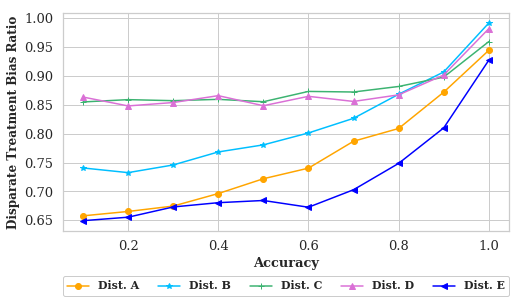

In [31]:
toplot = 'Algo_DT_biasratio'
from matplotlib.ticker import ScalarFormatter



plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')

ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

dfB[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[3],marker='*')
dfC[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[5],marker='+')
dfD[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[7],marker='^')
dfE[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[2],marker='<')

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)


plt.ylabel('Disparate Treatment Bias Ratio',fontsize=12,weight='bold')
plt.xlabel('Accuracy', fontsize =13,weight='bold')

plt.legend(['Dist. A', 'Dist. B', 'Dist. C', 'Dist. D', 'Dist. E'],
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=5,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('compare_dt_ratio.pdf', bbox_inches = 'tight')

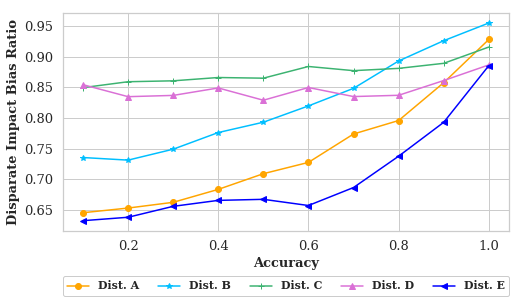

In [32]:
toplot = 'Algo_DI_biasratio'
from matplotlib.ticker import ScalarFormatter



plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')

ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

dfB[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[3],marker='*')
dfC[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[5],marker='+')
dfD[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[7],marker='^')
dfE[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[2],marker='<')

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)


plt.ylabel('Disparate Impact Bias Ratio',fontsize=13,weight='bold')
plt.xlabel('Accuracy', fontsize =13,weight='bold')

plt.legend(['Dist. A', 'Dist. B', 'Dist. C', 'Dist. D', 'Dist. E'],
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=5,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('compare_di_ratio.pdf', bbox_inches = 'tight')

In [103]:
# colors = ['orange','burlywood', 'blue', 'deepskyblue',  'deeppink','orchid']
# cats = ['White Men', 'White Women', 'Black Men', 'Black Women', 'Asian Men', 'Asian Women']
# f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
# handles = [f("s", colors[i]) for i in range(len(colors))]
# labels = cats
# legend = plt.legend(handles, labels, loc=3, framealpha=1, 
#                     frameon=True,ncol=len(colors),facecolor='white', prop = {'weight':'bold', 'size': 20})
# plt.gca().set_axis_off()
# plt.gca().set_facecolor('white')


# def export_legend(legend, filename="simulation_legend.pdf", expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
# plt.show()

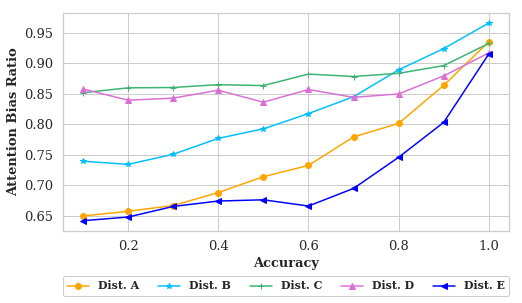

In [102]:
toplot = 'Algo_attention_biasratio'
from matplotlib.ticker import ScalarFormatter



plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')

ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

dfB[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[3],marker='*')
dfC[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[5],marker='+')
dfD[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[7],marker='^')
dfE[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[2],marker='<')

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)

plt.ylabel('Attention Bias Ratio',fontsize=13,weight='bold')
plt.xlabel('Accuracy', fontsize =13,weight='bold')

plt.legend(['Dist. A', 'Dist. B', 'Dist. C', 'Dist. D', 'Dist. E'],
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=5,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('compare_attention_ratio.pdf', bbox_inches = 'tight')

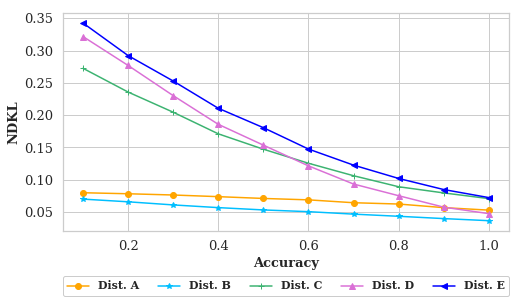

In [34]:
toplot = 'Algo NDKL'
from matplotlib.ticker import ScalarFormatter



plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')

ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

dfB[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[3],marker='*')
dfC[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[5],marker='+')
dfD[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[7],marker='^')
dfE[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[2],marker='<')

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)


plt.ylabel('NDKL',fontsize=13,weight='bold')
plt.xlabel('Accuracy', fontsize =13,weight='bold')

plt.legend(['Dist. A', 'Dist. B', 'Dist. C', 'Dist. D', 'Dist. E'],
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.3,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=5,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('compare_ndkl.pdf', bbox_inches = 'tight')

In [35]:
# dictpred = json.load(open('../ethcounts_rate.json')) 
# ethncolorpred = json.load(open('../ethncolor_rate.json')) 

# print(dictpred)
# print(ethncolorpred)

map_keys = {
    'white':'White',
    'api':  'Asian',
    'asian':'Asian',
    'black':'Black',
    'hispanic':'Latino',
    'latino':'Latino'
}   

def norm_dict(ethncolorpred):
    org_dict = {}
    for race1 in ethncolorpred:
        org_dict[map_keys[race1]]={}
        for race2 in ethncolorpred[race1]:
            org_dict[map_keys[race1]][map_keys[race2]]= ethncolorpred[race1][race2]
    return org_dict

In [36]:
cats = ['White_Male', 'White_Female', 'Black_Male', 'Black_Female', 'Latino_Male', 'Latino_Female', 'Asian_Male', 'Asian_Female']
color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
d2c = dict(zip(cats, color_list))

In [37]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})

# Case Studies

In [38]:
import json
dictpred = json.load(open('../ethcounts_rate.json')) 
# ethncolorpred = norm_dict(json.load(open('../ethncolor_rate.json')))
cnnpred = json.load(open('../eth_CNN_probs.json')) 
ethncolorpred = norm_dict(json.load(open('../ethncolor_major_probs.json')))
bisgpred = json.load(open('../surgeo_probs.json'))
nameprismpred = json.load(open('../nameprism_ethprobs.json'))
deepfacepred = json.load(open('../eth_genface_probs.json'))

In [39]:
import pprint
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(ethncolorpred)

{'Asian': {'Asian': 0.4177458486939534,
           'Black': 0.007971767967986891,
           'Latino': 0.0795601348583672,
           'White': 0.4947222484796925},
 'Black': {'Asian': 0.1356489679838461,
           'Black': 0.02522582112650309,
           'Latino': 0.04393063422489593,
           'White': 0.7951945766647549},
 'Latino': {'Asian': 0.06131009566594049,
            'Black': 0.010202562818830089,
            'Latino': 0.31740254116882943,
            'White': 0.6110848003464},
 'White': {'Asian': 0.12150850578319809,
           'Black': 0.031444105210971136,
           'Latino': 0.016651837953604212,
           'White': 0.8303955510522265}}


# UCI Adult Income Data

In [110]:
getdist(incomerank_og[:300])

{'White_Male': 0.7966666666666666,
 'White_Female': 0.13333333333333333,
 'Asian_Male': 0.04,
 'Black_Female': 0.006666666666666667,
 'Asian_Female': 0.006666666666666667,
 'Black_Male': 0.016666666666666666}

In [111]:
getdist_mispredicted(incomerank_shuffled_deepface[:300])

{'Black_Male': 0.10333333333333333,
 'White_Male': 0.6266666666666667,
 'Asian_Male': 0.13,
 'White_Female': 0.10666666666666667,
 'Asian_Female': 0.02666666666666667,
 'Black_Female': 0.006666666666666667}

In [112]:
getdist(incomerank_og)

{'White_Male': 0.6118999323867478,
 'White_Female': 0.26707234617985126,
 'Asian_Male': 0.019202163624070318,
 'Black_Female': 0.04354293441514537,
 'Asian_Female': 0.009330628803245436,
 'Black_Male': 0.048951994590939824}

In [113]:
getdist(incomedetconsort_shuff_deepface[:300])

{'White_Male': 0.7433333333333333,
 'White_Female': 0.22,
 'Black_Female': 0.01,
 'Asian_Male': 0.016666666666666666,
 'Asian_Female': 0.0033333333333333335,
 'Black_Male': 0.006666666666666667}

In [119]:
print([i for i in range(0,300) if incomedetconsort_shuff_deepface[:300][i]['real_attr']=='Asian_Male'])

print([incomedetconsort_shuff_deepface[i]['attr'] for i in [77, 196, 256, 266, 299]])

print([i for i in range(0,300) if incomedetconsort_shuff_deepface[:300][i]['attr']=='Asian_Male'])

print([incomedetconsort_shuff_deepface[i]['real_attr'] for i in [47, 99, 151, 200, 254]])

print([i for i in range(0,300) if incomerank_og[:300][i]['real_attr']=='Asian_Male'])




[77, 196, 256, 266, 299]
['White_Male', 'Black_Male', 'White_Male', 'White_Female', 'Black_Female']
[47, 99, 151, 200, 254]
['White_Male', 'White_Male', 'White_Male', 'White_Male', 'White_Male']
[75, 110, 112, 137, 152, 155, 167, 209, 212, 227, 252, 254]


In [121]:
print([i for i in range(0,300) if incomedetconsort_shuff_nameprism[:300][i]['real_attr']=='Asian_Male'])

print([incomedetconsort_shuff_nameprism[i]['attr'] for i in [151, 200, 254, 264, 268, 290]])

print([i for i in range(0,300) if incomedetconsort_shuff_nameprism[:300][i]['attr']=='Asian_Male'])

print([incomedetconsort_shuff_nameprism[i]['real_attr'] for i in [52, 93, 151, 200, 254]])

print([i for i in range(0,300) if incomerank_og[:300][i]['real_attr']=='Asian_Male'])




[151, 200, 254, 264, 268, 290]
['Asian_Male', 'Asian_Male', 'Asian_Male', 'White_Male', 'White_Male', 'White_Male']
[52, 93, 151, 200, 254]
['White_Male', 'White_Male', 'Asian_Male', 'Asian_Male', 'Asian_Male']
[75, 110, 112, 137, 152, 155, 167, 209, 212, 227, 252, 254]


In [40]:
incomerank_ogo = json.load(open('incomedatalist.json'))
from collections import Counter
import copy

In [41]:
# set([i['real_attr'] for i in incomerank_og])

In [42]:
incomerank_og = []
for item in incomerank_ogo:
    if item['real_attr'].split('_')[0] not in ['Other', 'NativeAm']:
        item['attr'] = item['real_attr']
        incomerank_og.append(item)

In [43]:
n_sim = 100
L = len(incomerank_og)
K = 300
incomedist = getdist(incomerank_og)

NDKL_dic = {}

attd_d = {}
geoattd_d = {}
DI_d = {}
DT_d = {}
skew_d = {}

for s in range(n_sim):
    print(s)
    global seedcount
#     print('seed', seedcount)
    seed_everything(seedcount)
    seedcount+=1
    
    incomerank_shuffled_ethncolor = misinterpret(copy.deepcopy(incomerank_og), ethncolorpred,'Ethncolor')
    incomerank_shuffled_cnn = misinterpret(copy.deepcopy(incomerank_og), cnnpred,'EthCnn')
    incomerank_shuffled_bisg = misinterpret(copy.deepcopy(incomerank_og), bisgpred,'BISG')
    incomerank_shuffled_nameprism = misinterpret(copy.deepcopy(incomerank_og), nameprismpred,'Nameprism')
    incomerank_shuffled_deepface = misinterpret(copy.deepcopy(incomerank_og), deepfacepred,'DeepFace')
    
    incomedetconsort_og = det_const_sort(incomerank_og,incomedist,K)
    #incomedetconsort_shuff_dict = det_const_sort(incomerank_shuffled_dict,incomedist,K)
    incomedetconsort_shuff_ethncolor = det_const_sort(incomerank_shuffled_ethncolor,incomedist,K)
    incomedetconsort_shuff_cnn = det_const_sort(incomerank_shuffled_cnn,incomedist,K)
    incomedetconsort_shuff_bisg = det_const_sort(incomerank_shuffled_bisg,incomedist,K)
    incomedetconsort_shuff_nameprism = det_const_sort(incomerank_shuffled_nameprism,incomedist,K)
    incomedetconsort_shuff_deepface = det_const_sort(incomerank_shuffled_deepface,incomedist,K)
    
    method_names = ['Baseline','Oracle','EthCnn','EthniColr','BISG','Nameprism','DeepFace']

    rankedlists = [incomerank_og, incomedetconsort_og,incomedetconsort_shuff_cnn, incomedetconsort_shuff_ethncolor,incomedetconsort_shuff_bisg, incomedetconsort_shuff_nameprism, incomedetconsort_shuff_deepface]

    for method_name, rankedlist in zip(method_names, rankedlists):
        if method_name not in NDKL_dic:
            NDKL_dic[method_name] = []
        NDKL_dic[method_name].append(NDKL(rankedlist[:K], incomedist))
        
#     maind = None

    dist = incomedist

    for method_name, rankedlist in zip(method_names, rankedlists):
#         attd = None
#         if method_name == 'PerfectInference':
#             ndkl,maind,DI,DT,skewd,geoattd = showmetrics(incomedetconsort_og[:K],dist)
#             attd = maind
#         else:
        print(method_name)
        ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
        if method_name not in attd_d:
            attd_d[method_name] = {}
        if method_name not in geoattd_d:
            geoattd_d[method_name] = {}
        if method_name not in DI_d:
            DI_d[method_name] = {}
        if method_name not in DT_d:
            DT_d[method_name] = {}
        if method_name not in skew_d:
            skew_d[method_name] = {}
        
        for cat in attd:
            if cat not in attd_d[method_name]:
                attd_d[method_name][cat] = []
            attd_d[method_name][cat].append(attd[cat])
            
        for cat in geoattd:
            if cat not in geoattd_d[method_name]:
                geoattd_d[method_name][cat] = []
            geoattd_d[method_name][cat].append(geoattd[cat])
            
        for cat in DI:
            if cat not in DI_d[method_name]:
                DI_d[method_name][cat] = []
            DI_d[method_name][cat].append(DI[cat])
            
        for cat in DT:
            if cat not in DT_d[method_name]:
                DT_d[method_name][cat] = []
            DT_d[method_name][cat].append(DT[cat])
            
        for cat in skewd:
            if cat not in skew_d[method_name]:
                skew_d[method_name][cat] = []
            skew_d[method_name][cat].append(skewd[cat])

0
Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.16669458

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597, 'Black_Female': 0.15312503925569784, 'Black_Male': 0.34048308598778765, 'Asian_Male': 2.0830421894578097, 'White_Female': 0.4992423813177672}
	 mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 0.34857304244236986, 'White_Female': 0.32684120766835795, 'Asian_Male': 0.15719671035319746, 'Black_Female': 0.11121714920866693, 'Asian_Female': 0.14336025100329935, 'Black_Male': 0.02964267026706855}
	 mean exposure : 0.18613850515716002
	 Standard deviation of exposure : 0.11471267862726234
	 Exposure bias ratio:  0.08504005375564698
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 0.4008877552958177, 'White_Female': 0.3763792333560342, 'Asian_Male': 0.18356259899294428, 'Black_Female': 0.1302655470731386, 'Asian_Female': 0.1666945894

In [44]:
attdloop_inc = []
geoattdloop_inc = []
ndklloop_inc = NDKL_dic
DIloop_inc = []
DTloop_inc = []
skewloop_inc = []
ABR_inc = {}
DIBR_inc = {}
DTBR_inc = {}


for method_name in method_names:
    attd = {}
    for cat in attd_d[method_name]:
        attd[cat]= np.mean(attd_d[method_name][cat])
    attdloop_inc.append(attd)
    
    geoattd = {}
    for cat in geoattd_d[method_name]:
        geoattd[cat]= np.mean(geoattd_d[method_name][cat])
    geoattdloop_inc.append(geoattd)
    
    DI = {}
    for cat in DI_d[method_name]:
        DI[cat]= np.mean(DI_d[method_name][cat])
    DIloop_inc.append(DI)
    
    DT = {}
    for cat in DT_d[method_name]:
        DT[cat]= np.mean(DT_d[method_name][cat])
    DTloop_inc.append(DT)
    
    skewd = {}
    for cat in skew_d[method_name]:
        skewd[cat]= np.mean(skew_d[method_name][cat])
    skewloop_inc.append(skewd)

    ABR_inc[method_name]=min(attd.values())/max(attd.values())
    DIBR_inc[method_name]=min(DI.values())/max(DI.values())
    DTBR_inc[method_name]=min(DT.values())/max(DT.values())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.209139 \\
Oracle    &  0.049886 \\
EthCnn    &  0.101861 \\
EthniColr &  0.110460 \\
BISG      &  0.107098 \\
Nameprism &  0.097942 \\
DeepFace  &  0.144990 \\
\bottomrule
\end{tabular}



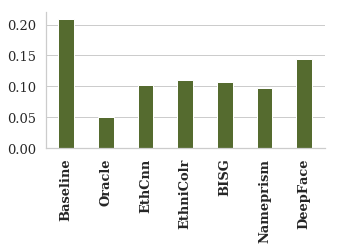

In [45]:
LL = {}
for i in ndklloop_inc:
    LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='darkolivegreen',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('income_NDKL.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.085040 \\
Oracle    &  0.516815 \\
EthCnn    &  0.144402 \\
EthniColr &  0.086269 \\
BISG      &  0.067878 \\
Nameprism &  0.441143 \\
DeepFace  &  0.391575 \\
\bottomrule
\end{tabular}



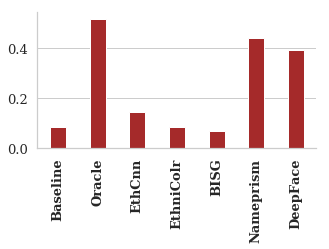

In [46]:
LL = ABR_inc
# for i in ndklloop_inc:
#     LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='brown',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('income_ABR.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.078162 \\
Oracle    &  0.486240 \\
EthCnn    &  0.131727 \\
EthniColr &  0.078796 \\
BISG      &  0.062598 \\
Nameprism &  0.360806 \\
DeepFace  &  0.344563 \\
\bottomrule
\end{tabular}



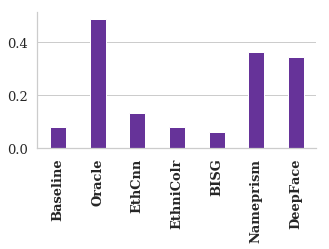

In [47]:
LL = DIBR_inc
# for i in ndklloop_inc:
#     LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='rebeccapurple',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('income_DIBR.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.088904 \\
Oracle    &  0.529218 \\
EthCnn    &  0.152814 \\
EthniColr &  0.089018 \\
BISG      &  0.070836 \\
Nameprism &  0.422123 \\
DeepFace  &  0.435295 \\
\bottomrule
\end{tabular}



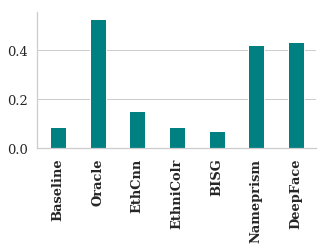

In [48]:
LL = DTBR_inc
# for i in ndklloop_inc:
#     LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='teal',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('income_DTBR.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

In [49]:
# #This is a simple last name frequency based classifier, not very accurate. Will also add charts for nameprism 
# #when we get access to it
# import copy 

# #incomerank_shuffled_dict = misinterpret(copy.deepcopy(incomerank_og), dictpred)
# incomerank_shuffled_ethncolor = misinterpret(copy.deepcopy(incomerank_og), ethncolorpred)
# incomerank_shuffled_cnn = misinterpret(copy.deepcopy(incomerank_og), cnnpred)
# incomerank_shuffled_bisg = misinterpret(copy.deepcopy(incomerank_og), bisgpred)
# incomerank_shuffled_nameprism = misinterpret(copy.deepcopy(incomerank_og), nameprismpred)
# incomerank_shuffled_deepface = misinterpret(copy.deepcopy(incomerank_og), deepfacepred)

In [50]:
# L = len(incomerank_og)
# K = 300

In [51]:
# incomedist = getdist(incomerank_og)

In [52]:
# incomedetconsort_og = det_const_sort(incomerank_og,incomedist,K)
# #incomedetconsort_shuff_dict = det_const_sort(incomerank_shuffled_dict,incomedist,K)
# incomedetconsort_shuff_ethncolor = det_const_sort(incomerank_shuffled_ethncolor,incomedist,K)
# incomedetconsort_shuff_cnn = det_const_sort(incomerank_shuffled_cnn,incomedist,K)
# incomedetconsort_shuff_bisg = det_const_sort(incomerank_shuffled_bisg,incomedist,K)
# incomedetconsort_shuff_nameprism = det_const_sort(incomerank_shuffled_nameprism,incomedist,K)
# incomedetconsort_shuff_deepface = det_const_sort(incomerank_shuffled_deepface,incomedist,K)

In [53]:
# len(incomerank_og)

In [54]:
# method_names = ['Vanilla/Unfair','PerfectInference','EthCnn','Ethncolor','BISG','Nameprism','Deepface']

# rankedlists = [incomerank_og, incomedetconsort_og,incomedetconsort_shuff_cnn, incomedetconsort_shuff_ethncolor,incomedetconsort_shuff_bisg, incomedetconsort_shuff_nameprism, incomedetconsort_shuff_deepface]

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print(method_name, NDKL(rankedlist[:K], incomedist))

### Logarithmic Attention

In [55]:
# maind = None

# attdloop = []
# geoattdloop = []
# ndklloop = []
# DIloop = []
# DTloop = []
# skewloop = []

# dist = incomedist

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print('\n\n',method_name.title())
#     attd = None
#     if method_name == 'PerfectInference':
#         ndkl,maind,DI,DT,skewd,geoattd = showmetrics(incomedetconsort_og[:K],dist)
#         attd = maind
#     else:
#         ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
#     attdloop.append(attd)
#     ndklloop.append(ndkl)
#     DIloop.append(DI)
#     DTloop.append(DT)
#     skewloop.append(skewd)
#     geoattdloop.append(geoattd)

# #     if method_name not in ['Vanilla/Unfair','PerfectInference']:
# #         getheatmap(maind,attd,'Perfect Inference',method_name.title())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Asian\_Female &  White\_Male &  Black\_Female &  Black\_Male &  Asian\_Male &  White\_Female &      NDKL \\
\midrule
Baseline  &      0.714523 &    1.301955 &      0.153125 &    0.340483 &    2.083042 &      0.499242 &  0.209139 \\
Oracle    &      0.714523 &    1.013238 &      0.995186 &    0.953316 &    0.867965 &      0.998481 &  0.049886 \\
EthCnn    &      1.407507 &    1.045214 &      0.631569 &    0.170610 &    1.866064 &      1.033553 &  0.101861 \\
EthniColr &      0.680683 &    1.067549 &      0.466984 &    0.161914 &    1.163055 &      1.086971 &  0.110460 \\
BISG      &      1.211043 &    1.066078 &      0.533584 &    0.076008 &    1.480711 &      1.056393 &  0.107098 \\
Nameprism &      1.010393 &    1.061121 &      0.682093 &    0.143607 &    1.435579 &      1.039543 &  0.097942 \\
DeepFace  &      0.486649 &    1.222803 &      0.232769 &    0.155333 &    0.657930 &      0.822624 &  0.144990 \\
\bottomrule
\end{tabular}



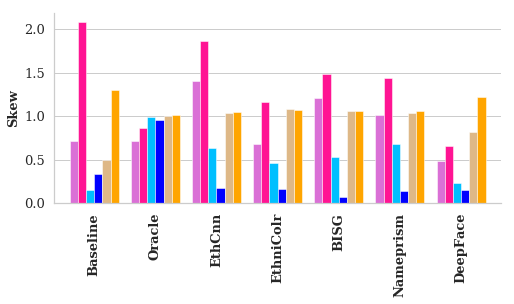

In [56]:
#fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(10,4))
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# # rc('text', usetex=True)

df = pd.DataFrame(skewloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,3.5)
plt.rcParams["font.family"] = 'DejaVu Serif'






#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)


#plt.legend(loc=(1.04,0))
plt.ylabel("Skew",size=13,weight='bold')
plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)






# plt.ylabel("Population Skew")
plt.savefig('income_skew.pdf', bbox_inches = 'tight')

# print(dft.to_latex())
LL = {}
for i in ndklloop_inc:
    LL[i]=np.mean(ndklloop_inc[i])
dft['NDKL'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())

\begin{table*}[t]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  White\_Male &  White\_Female &  Asian\_Male &  Black\_Female &  Asian\_Female &  Black\_Male &       ABR \\
\midrule
Baseline  &    0.348573 &      0.326841 &    0.157197 &      0.111217 &      0.143360 &    0.029643 &  0.085040 \\
Oracle    &    0.343497 &      0.321459 &    0.254569 &      0.278332 &      0.177524 &    0.290933 &  0.516815 \\
EthCnn    &    0.351381 &      0.323389 &    0.178502 &      0.211896 &      0.239819 &    0.050740 &  0.144402 \\
EthniColr &    0.349636 &      0.317140 &    0.127533 &      0.211170 &      0.317344 &    0.030163 &  0.086269 \\
BISG      &    0.346789 &      0.321664 &    0.191870 &      0.203879 &      0.231010 &    0.023539 &  0.067878 \\
Nameprism &    0.347707 &      0.324725 &    0.153727 &      0.212778 &      0.229856 &    0.153388 &  0.441143 \\
DeepFace  &    0.340048 &      0.316158 &    0.185071 &      0.218350 &      0.213596 &    0.133154 &  0.391575 \\
\bottomr

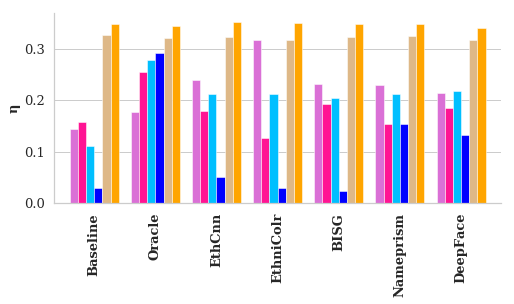

In [57]:
df = pd.DataFrame(attdloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns
plt.rcParams["figure.figsize"] = (8,3.5)


dft['X'] = dft.index

ax = dft.plot(x="X", y=sorted(list(dftcol)), logy = False ,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.grid(False)




# plt.xlabel("Inference Algorithm")
# plt.ylabel("mean Attention")
plt.xlabel(None)
plt.ylabel("η",size=13,weight='bold')
plt.xticks(rotation=90,weight='bold')

for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)


plt.savefig('income_attention.pdf', bbox_inches = 'tight')

print('\\begin{table*}[t]')
print('\centering')
LL = ABR_inc
dft['ABR'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table*}')

\begin{table}[!htbp]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  White\_Male &  White\_Female &  Asian\_Male &  Black\_Female &  Asian\_Female &  Black\_Male &      DIBR \\
\midrule
Baseline  &    0.316067 &      0.293841 &    0.136607 &      0.095413 &      0.123301 &    0.024704 &  0.078162 \\
Oracle    &    0.314211 &      0.282291 &    0.224148 &      0.227083 &      0.152782 &    0.240621 &  0.486240 \\
EthCnn    &    0.320793 &      0.282926 &    0.155169 &      0.173577 &      0.199964 &    0.042257 &  0.131727 \\
EthniColr &    0.317909 &      0.271225 &    0.110970 &      0.171326 &      0.269835 &    0.025050 &  0.078796 \\
BISG      &    0.316508 &      0.281517 &    0.167861 &      0.170351 &      0.195096 &    0.019813 &  0.062598 \\
Nameprism &    0.315550 &      0.272711 &    0.134167 &      0.133985 &      0.194438 &    0.113852 &  0.360806 \\
DeepFace  &    0.306817 &      0.276627 &    0.158606 &      0.178642 &      0.179122 &    0.105718 &  0.344563 \\
\bott

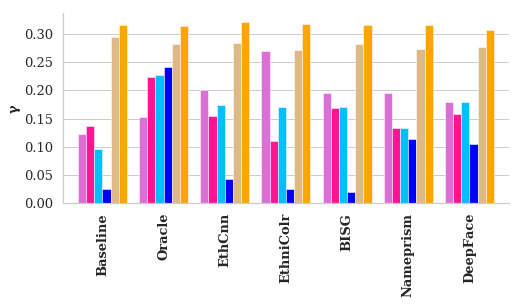

In [58]:
df = pd.DataFrame(DIloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns
plt.rcParams["figure.figsize"] = (8,3.5)


dft['X'] = dft.index

ax = dft.plot(x="X", y=sorted(list(dftcol)),logy = False, width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.grid(False)



plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')

plt.ylabel("γ",size=13,weight='bold')

for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)
#plt.xlabel("Inference Algorithm")
#plt.ylabel("mean Disparate Impact")

plt.savefig('income_DI.pdf', bbox_inches = 'tight')

print('\\begin{table}[!htbp]')
print('\centering')
LL = DIBR_inc
dft['DIBR'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table*}')

\begin{table}[!htbp]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  White\_Male &  White\_Female &  Asian\_Male &  Black\_Female &  Asian\_Female &  Black\_Male &      DTBR \\
\midrule
Baseline  &    0.400888 &      0.376379 &    0.183563 &      0.130266 &      0.166695 &    0.035641 &  0.088904 \\
Oracle    &    0.390045 &      0.388605 &    0.292054 &      0.377746 &      0.206419 &    0.363571 &  0.529218 \\
EthCnn    &    0.399681 &      0.394301 &    0.208107 &      0.278110 &      0.301709 &    0.061077 &  0.152814 \\
EthniColr &    0.400163 &      0.407846 &    0.148654 &      0.279696 &      0.379904 &    0.036306 &  0.089018 \\
BISG      &    0.394817 &      0.391294 &    0.222183 &      0.256275 &      0.283343 &    0.027967 &  0.070836 \\
Nameprism &    0.401288 &      0.422540 &    0.178364 &      0.407245 &      0.279132 &    0.224747 &  0.422123 \\
DeepFace  &    0.395148 &      0.384300 &    0.219415 &      0.283587 &      0.257879 &    0.172006 &  0.435295 \\
\bott

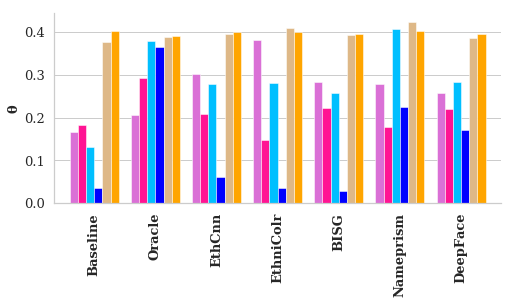

In [59]:
df = pd.DataFrame(DTloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns
plt.rcParams["figure.figsize"] = (8,3.5)


dft['X'] = dft.index

ax = dft.plot(x="X", y=sorted(list(dftcol)),logy = False, width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.grid(False)



plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')

plt.ylabel("θ",size=13,weight='bold')

for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)
#plt.xlabel("Inference Algorithm")
#plt.ylabel("mean Disparate Impact")

plt.savefig('income_DT.pdf', bbox_inches = 'tight')

print('\\begin{table}[!htbp]')
print('\centering')
LL = DTBR_inc
dft['DTBR'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table*}')

In [60]:
# from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# from matplotlib.ticker import ScalarFormatter


    
# df = pd.DataFrame(DTloop_inc).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index
# plt.rcParams["figure.figsize"] = (8,4)

# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4]})


# dft.plot(x="X",y=sorted(list(dftcol)),logy = False, width = 0.7, 
#               edgecolor='white',linewidth=0.2,kind="bar",color=map(d2c.get,sorted(list(dftcol))), ax = ax1)
# dft.plot(x="X",y=sorted(list(dftcol)),logy = False, width = 0.7, 
#               edgecolor='white',linewidth=0.2,kind="bar",color=map(d2c.get,sorted(list(dftcol))), ax = ax2)

# for ax in [ax1,ax2]:
#     ax.set_facecolor('white')
#     ax.get_legend().remove()
#     ax.tick_params(axis='x', which='both',labelsize=13)
#     ax.tick_params(axis='y', which='both',labelsize=11)
#     # ax.xaxis.set_minor_locator(AutoMinorLocator())
#     # ax.yaxis.set_minor_locator(AutoMinorLocator())
#     ax.yaxis.set_minor_formatter(ScalarFormatter())
#     ax.yaxis.set_major_formatter(ScalarFormatter())

#     ax.yaxis.grid(True,which='both')
#     ax.xaxis.grid(False)

# ax1.set_ylim(110, 130)  # outliers only
# ax2.set_ylim(0, 35)  # most of the data

# ax1.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# # ax1.xaxis.tick_top()
# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# # plt.legend(loc=(1.04,0),ncol=len(dft.columns))
# # plt.xlabel("Inference Algorithm")
# plt.xlabel(None)
# plt.xticks(rotation=90,weight='bold')

# plt.ylabel("θ",size=13,weight='bold')


# # d = .015  # how big to make the diagonal lines in axes coordinates
# # # arguments to pass to plot, just so we don't keep repeating them
# # kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# # ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# # # ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# # d = .015  # how big to make the diagonal lines in axes coordinates

# # kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# # ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# # # ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal



# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     ax1.spines[spine].set_visible(False)
#     ax2.spines[spine].set_visible(False)
    
# #plt.ylabel("mean Disparate Treatment")
# # plt.gca().set_axis_off()
# # ax.axis('off')
# # plt.show()
# # plt.minorticks_on()

# plt.savefig('income_DT.eps', bbox_inches = 'tight')


# print('\\begin{table}[!htbp]')
# print('\centering')
# print(dft.to_latex())
# print('\end{table}')

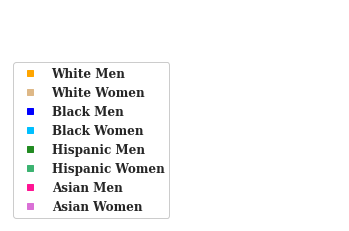

In [19]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["font.family"] = 'DejaVu Serif'

colors = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
cats = ['White Men', 'White Women', 'Black Men', 'Black Women', 'Hispanic Men', 'Hispanic Women', 'Asian Men', 'Asian Women']

#colors = ['orange','burlywood', 'forestgreen',  'deeppink','orchid']
#cats = ['White Men', 'White Women',   'Hispanic Men',  'Asian Men', 'Asian Women']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(colors))]
labels = cats
legend = plt.legend(handles, labels, loc=3, framealpha=1,
                    frameon=True,ncol=1,facecolor='white', prop = {'weight':'bold', 'size': 12})
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')


def export_legend(legend, filename="db_legend.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [62]:
# df = pd.DataFrame(geoattdloop).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index

# ax = dft.plot(x="X", y=sorted(list(dftcol)),logy = True, width = 0.7, edgecolor='white',linewidth=0.2,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
# ax.set_facecolor('white')
# ax.get_legend().remove()

# plt.xlabel("None")

# dft

# # plt.xlabel("Inference Algorithm")
# # plt.ylabel("mean Geometric Attention")

# Compas Data

In [63]:
compas = pd.read_csv('compas_baseline_score.csv')
# compasbaseline['race+gender'] = compasbaseline['race'].astype(str)+'_'+compasbaseline['sex'].astype(str)

compasrank_og = []
for i, row in compas.iterrows():
    if row['race']=='Other':
        continue
    if row['race']=='Asian':
        continue
    if row['race']=='African-American':
        row['race'] = 'Black'
    if row['race']=='Caucasian':
        row['race'] = 'White'
    if row['race']=='Hispanic':
        row['race'] = 'Latino'
    if row['race']=='Native American':
        continue
    print(i, end='\r')
    compasrank_og.append({'attr': str(row['race'])+'_'+str(row['sex']),'real_attr':str(row['race'])+'_'+str(row['sex']),'score':row['two_year_recid_pred']})

In [64]:
compasrank_og.sort(key=lambda x:x['score'],reverse=True)

In [65]:
#getdist_mispredicted(compasrank_shuffled_ethncolor) # pred_dict that EthnColor sees

In [66]:
#getdist(compasdetconsort_shuff_ethncolor[:300])

In [67]:
#compasdist                                         # true distribution

In [68]:
#getdist(compasrank_og[:300])

In [69]:
#getdist(compasdetconsort_og[:300])

In [70]:
#getdist_mispredicted(compasrank_shuffled_ethncolor[:300])


In [71]:
#getdist_mispredicted(compasrank_shuffled_cnn[:300])


In [72]:
#getdist(compasdetconsort_shuff_cnn[:300])

In [73]:
# print(0.54*300,0.23*300 , 0.03*300, 0.88*300)

# print(0.59*300, 0.33*300)

# print(0.69*300, 0.05*300)

In [74]:
n_sim = 100
L = len(compasrank_og)
K = 300
compasdist = getdist(compasrank_og)

NDKL_dic = {}

attd_d = {}
geoattd_d = {}
DI_d = {}
DT_d = {}
skew_d = {}

for s in range(n_sim):
    print(s)
    global seedcount
#     print('seed', seedcount)
    seed_everything(seedcount)
    seedcount+=1

    compasrank_shuffled_ethncolor = misinterpret(copy.deepcopy(compasrank_og), ethncolorpred,'Ethncolor')
    compasrank_shuffled_cnn = misinterpret(copy.deepcopy(compasrank_og), cnnpred,'EthCnn')
    compasrank_shuffled_bisg = misinterpret(copy.deepcopy(compasrank_og), bisgpred,'BISG')
    compasrank_shuffled_nameprism = misinterpret(copy.deepcopy(compasrank_og), nameprismpred,'Nameprism')
    compasrank_shuffled_deepface = misinterpret(copy.deepcopy(compasrank_og), deepfacepred,'DeepFace')
    
    compasdetconsort_og = det_const_sort(compasrank_og,compasdist,K)
    #compasdetconsort_shuff_dict = det_const_sort(compasrank_shuffled_dict,compasdist,K)
    compasdetconsort_shuff_ethncolor = det_const_sort(compasrank_shuffled_ethncolor,compasdist,K)
    compasdetconsort_shuff_cnn = det_const_sort(compasrank_shuffled_cnn,compasdist,K)
    compasdetconsort_shuff_bisg = det_const_sort(compasrank_shuffled_bisg,compasdist,K)
    compasdetconsort_shuff_nameprism = det_const_sort(compasrank_shuffled_nameprism,compasdist,K)
    compasdetconsort_shuff_deepface = det_const_sort(compasrank_shuffled_deepface,compasdist,K)
    
    method_names = ['Baseline','Oracle','EthCnn','EthniColr','BISG','Nameprism','DeepFace']

    rankedlists = [compasrank_og, compasdetconsort_og,compasdetconsort_shuff_cnn, compasdetconsort_shuff_ethncolor,compasdetconsort_shuff_bisg, compasdetconsort_shuff_nameprism, compasdetconsort_shuff_deepface]

    for method_name, rankedlist in zip(method_names, rankedlists):
        if method_name not in NDKL_dic:
            NDKL_dic[method_name] = []
        NDKL_dic[method_name].append(NDKL(rankedlist[:K], compasdist))
        
#     maind = None

    dist = compasdist

    for method_name, rankedlist in zip(method_names, rankedlists):
#         attd = None
#         if method_name == 'PerfectInference':
#             ndkl,maind,DI,DT,skewd,geoattd = showmetrics(compasdetconsort_og[:K],dist)
#             attd = maind
#         else:
        print(method_name)
        ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
        if method_name not in attd_d:
            attd_d[method_name] = {}
        if method_name not in geoattd_d:
            geoattd_d[method_name] = {}
        if method_name not in DI_d:
            DI_d[method_name] = {}
        if method_name not in DT_d:
            DT_d[method_name] = {}
        if method_name not in skew_d:
            skew_d[method_name] = {}
        
        for cat in attd:
            if cat not in attd_d[method_name]:
                attd_d[method_name][cat] = []
            attd_d[method_name][cat].append(attd[cat])
            
        for cat in geoattd:
            if cat not in geoattd_d[method_name]:
                geoattd_d[method_name][cat] = []
            geoattd_d[method_name][cat].append(geoattd[cat])
            
        for cat in DI:
            if cat not in DI_d[method_name]:
                DI_d[method_name][cat] = []
            DI_d[method_name][cat].append(DI[cat])
            
        for cat in DT:
            if cat not in DT_d[method_name]:
                DT_d[method_name][cat] = []
            DT_d[method_name][cat].append(DT[cat])
            
        for cat in skewd:
            if cat not in skew_d[method_name]:
                skew_d[method_name][cat] = []
            skew_d[method_name][cat].append(skewd[cat])

0
Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.21185728

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

Baseline
NDKL of this ranking:  0.3204445214050419
Skew Measure:  {'Latino_Male': 0.45176387035710125, 'Latino_Female': 0.23529786989301138, 'White_Male': 0.36890416542356247, 'Black_Female': 0.3513729573856022, 'Black_Male': 1.7850211184626004, 'White_Female': 0.200113338058325}
	 mean skew : 0.5654122199300338
	 Standard deviation of skew : 0.5518467165397231
	 Skew bias ratio:  0.11210698629194833
Groupwise Exposure:  {'Black_Male': 0.33255810422676213, 'White_Male': 0.34095174284653457, 'Latino_Male': 0.30171636568830434, 'White_Female': 0.5127976639207918, 'Black_Female': 0.18816739144090391, 'Latino_Female': 0.0823848802165527}
	 mean exposure : 0.29309602472330826
	 Standard deviation of exposure : 0.13391524093128257
	 Exposure bias ratio:  0.16065767458191482
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 0.3668161695824284, 'White_Male': 0.3776396568962377, 'Latino_Male': 0.33388401542240626, 'White_Female': 0.5573924222922986, 'Black_Female': 0.2118572804

In [75]:
attdloop_comp = []
geoattdloop_comp = []
ndklloop_comp = NDKL_dic
DIloop_comp = []
DTloop_comp = []
skewloop_comp = []

ABR = {}
DIBR = {}
DTBR = {}


for method_name in method_names:
    attd = {}
    for cat in attd_d[method_name]:
        attd[cat]= np.mean(attd_d[method_name][cat])
    attdloop_comp.append(attd)
    
    geoattd = {}
    for cat in geoattd_d[method_name]:
        geoattd[cat]= np.mean(geoattd_d[method_name][cat])
    geoattdloop_comp.append(geoattd)
    
    DI = {}
    for cat in DI_d[method_name]:
        DI[cat]= np.mean(DI_d[method_name][cat])
    DIloop_comp.append(DI)
    
    DT = {}
    for cat in DT_d[method_name]:
        DT[cat]= np.mean(DT_d[method_name][cat])
    DTloop_comp.append(DT)
    
    skewd = {}
    for cat in skew_d[method_name]:
        skewd[cat]= np.mean(skew_d[method_name][cat])
    skewloop_comp.append(skewd)
    
    ABR[method_name]=min(attd.values())/max(attd.values())
    DIBR[method_name]=min(DI.values())/max(DI.values())
    DTBR[method_name]=min(DT.values())/max(DT.values())
    
    

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.320445 \\
Oracle    &  0.055878 \\
EthCnn    &  0.232731 \\
EthniColr &  0.130036 \\
BISG      &  0.224306 \\
Nameprism &  0.199334 \\
DeepFace  &  0.231875 \\
\bottomrule
\end{tabular}



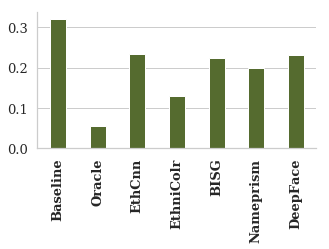

In [76]:
LL = {}
for i in ndklloop_comp:
    LL[i]=np.mean(ndklloop_comp[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='darkolivegreen',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('compas_NDKL.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.160658 \\
Oracle    &  0.575210 \\
EthCnn    &  0.524148 \\
EthniColr &  0.685683 \\
BISG      &  0.587593 \\
Nameprism &  0.546213 \\
DeepFace  &  0.569820 \\
\bottomrule
\end{tabular}



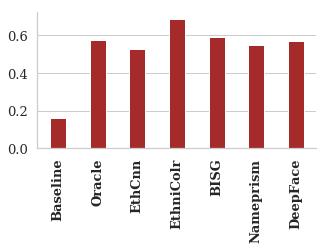

In [77]:
LL = ABR
# for i in ndklloop_inc:
#     LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='brown',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('compas_ABR.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.150034 \\
Oracle    &  0.496569 \\
EthCnn    &  0.439499 \\
EthniColr &  0.631690 \\
BISG      &  0.504697 \\
Nameprism &  0.502172 \\
DeepFace  &  0.555104 \\
\bottomrule
\end{tabular}



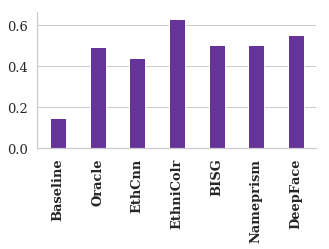

In [78]:
LL = DIBR
# for i in ndklloop_inc:
#     LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='rebeccapurple',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('compas_DIBR.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Baseline  &  0.166372 \\
Oracle    &  0.736357 \\
EthCnn    &  0.672160 \\
EthniColr &  0.566840 \\
BISG      &  0.687507 \\
Nameprism &  0.587152 \\
DeepFace  &  0.564769 \\
\bottomrule
\end{tabular}



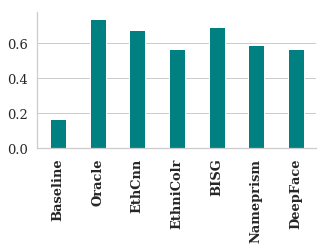

In [79]:
LL = DTBR
# for i in ndklloop_inc:
#     LL[i]=np.mean(ndklloop_inc[i])

    
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["font.family"] = 'DejaVu Serif'

plt.bar(LL.keys(), LL.values(),color='teal',width = 0.4)
ax = plt.gca()
ax.set_facecolor('white')
# ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)

plt.savefig('compas_DTBR.pdf', bbox_inches = 'tight')

print((pd.DataFrame([LL]).T).to_latex())

In [80]:


# #This is a simple last name frequency based classifier, not very accurate. Will also add charts for nameprism 
# #when we get access to it
# import copy 

# #compasbaseline_rank_shuffled_dict = misinterpret(copy.deepcopy(compasbaseline_original_rank), dictpred)
# compasbaseline_rank_shuffled_cnn = misinterpret(copy.deepcopy(compasbaseline_original_rank), cnnpred)
# compasbaseline_rank_shuffled_ethncolor = misinterpret(copy.deepcopy(compasbaseline_original_rank), ethncolorpred)
# compasbaseline_rank_shuffled_bisg = misinterpret(copy.deepcopy(compasbaseline_original_rank), bisgpred)
# compasbaseline_rank_shuffled_nameprism = misinterpret(copy.deepcopy(compasbaseline_original_rank), nameprismpred)
# compasbaseline_rank_shuffled_deepface = misinterpret(copy.deepcopy(compasbaseline_original_rank), deepfacepred)

In [81]:
# compasdist = getdist(compasbaseline_original_rank)

In [82]:
# set([i['attr'] for i in compasbaseline_original_rank])

In [83]:
# L = len(compasbaseline_original_rank)
# K = 250

In [84]:
# compasdetconsort_og = det_const_sort(compasbaseline_original_rank,compasdist,K)
# #compasdetconsort_shuff_dict = det_const_sort(compasbaseline_rank_shuffled_dict,compasdist,K)
# compasdetconsort_shuff_ethncolor = det_const_sort(compasbaseline_rank_shuffled_ethncolor,compasdist,K)
# compasdetconsort_shuff_cnn = det_const_sort(compasbaseline_rank_shuffled_cnn,compasdist,K)
# compasdetconsort_shuff_bisg = det_const_sort(compasbaseline_rank_shuffled_bisg,compasdist,K)
# compasdetconsort_shuff_nameprism = det_const_sort(compasbaseline_rank_shuffled_nameprism,compasdist,K)
# compasdetconsort_shuff_deepface = det_const_sort(compasbaseline_rank_shuffled_deepface,compasdist,K)

In [85]:
# method_names = ['vanilla - unfair','perfectinference','cnn','ethncolor','bisg','nameprism','deepface']

# rankedlists = [compasbaseline_original_rank, compasdetconsort_og,compasdetconsort_shuff_cnn, compasdetconsort_shuff_ethncolor, compasdetconsort_shuff_bisg, compasdetconsort_shuff_nameprism, compasdetconsort_shuff_deepface]

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print(method_name, NDKL(rankedlist[:K], compasdist))

### Logarithmic attention

In [86]:
# maind = None

# attdloop = []
# ndklloop = []
# DIloop = []
# DTloop = []
# skewloop = []
# geoattdloop = []

# dist = compasdist

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print('\n\n',method_name.title())
#     attd = None
#     if method_name == 'perfectinference':
#         ndkl,maind,DI,DT,skewd,geoattd = showmetrics(compasdetconsort_og[:K],dist)
#         attd = maind
#     else:
#         ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
#     attdloop.append(attd)
#     ndklloop.append(ndkl)
#     DIloop.append(DI)
#     DTloop.append(DT)
#     skewloop.append(skewd)
#     geoattdloop.append(geoattd)

#     if method_name not in ['vanilla - unfair','perfectinference']:
#         getheatmap(maind,attd,'Perfect Inference',method_name.title())

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  Latino\_Male &  Latino\_Female &  White\_Male &  Black\_Female &  Black\_Male &  White\_Female &      NDKL \\
\midrule
Baseline  &     0.451764 &       0.235298 &    0.368904 &      0.351373 &    1.785021 &      0.200113 &  0.209139 \\
Oracle    &     0.993864 &       0.940980 &    1.011505 &      0.983825 &    1.006371 &      0.960498 &  0.049886 \\
EthCnn    &     0.940106 &       0.868059 &    0.183859 &      1.440596 &    1.523512 &      0.466248 &  0.101861 \\
EthniColr &     0.505522 &       0.534037 &    0.766127 &      1.207995 &    1.225054 &      0.840838 &  0.110460 \\
BISG      &     0.928360 &       0.790434 &    0.206707 &      1.431461 &    1.513816 &      0.476253 &  0.107098 \\
Nameprism &     1.027746 &       0.896287 &    0.309404 &      1.445516 &    1.411930 &      0.563898 &  0.097942 \\
DeepFace  &     0.645565 &       0.378787 &    0.538955 &      0.459593 &    1.580956 &      0.420625 &  0.144

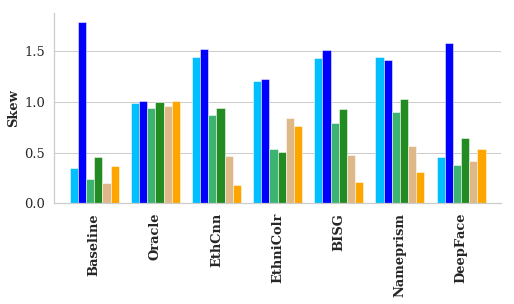

In [87]:
df = pd.DataFrame(skewloop_comp).T
df.columns = method_names
from matplotlib.ticker import ScalarFormatter

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,3.5)
plt.rcParams["font.family"] = 'DejaVu Serif'



#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8,logy=False ,edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.grid(True,which='both')

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")


for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)


plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')


plt.ylabel("Skew",weight='bold',size=13)
plt.savefig('compas_skew.pdf', bbox_inches = 'tight')

print('\\begin{table}[H]')
print('\centering')
LL = {}
for i in ndklloop_comp:
    LL[i]=np.mean(ndklloop_inc[i])
dft['NDKL'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  Black\_Male &  White\_Male &  Latino\_Male &  White\_Female &  Black\_Female &  Latino\_Female &       ABR \\
\midrule
Baseline  &    0.332558 &    0.340952 &     0.301716 &      0.512798 &      0.188167 &       0.082385 &  0.160658 \\
Oracle    &    0.348578 &    0.323225 &     0.310127 &      0.311350 &      0.307135 &       0.200505 &  0.575210 \\
EthCnn    &    0.331793 &    0.440179 &     0.307809 &      0.411868 &      0.279124 &       0.230719 &  0.524148 \\
EthniColr &    0.369293 &    0.266314 &     0.253218 &      0.354658 &      0.277723 &       0.255570 &  0.685683 \\
BISG      &    0.332721 &    0.423985 &     0.299121 &      0.417091 &      0.274884 &       0.249131 &  0.587593 \\
Nameprism &    0.350770 &    0.335751 &     0.236233 &      0.387410 &      0.276100 &       0.211608 &  0.546213 \\
DeepFace  &    0.345156 &    0.298206 &     0.294533 &      0.374866 &      0.213606 &       0.246038 &  0.569

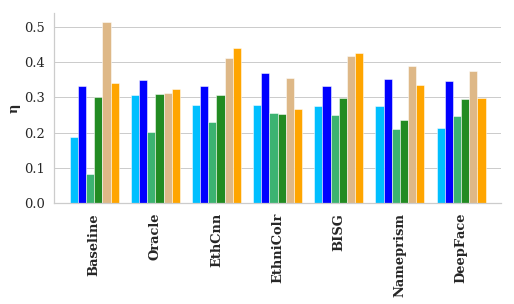

In [88]:
df = pd.DataFrame(attdloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,3.5)




#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),logy=False,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.grid(True,which='both')

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")


for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)


plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')


plt.ylabel("η",weight='bold',size=13)


# plt.ylabel("Population Skew")
plt.savefig('compas_attention.pdf', bbox_inches = 'tight')

print('\\begin{table}[H]')
print('\centering')
LL = ABR
dft['ABR'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  Black\_Male &  White\_Male &  Latino\_Male &  White\_Female &  Black\_Female &  Latino\_Female &      DTBR \\
\midrule
Baseline  &    0.366816 &    0.377640 &     0.333884 &      0.557392 &      0.211857 &       0.092734 &  0.166372 \\
Oracle    &    0.373015 &    0.386776 &     0.365779 &      0.408358 &      0.371788 &       0.300697 &  0.736357 \\
EthCnn    &    0.370030 &    0.477108 &     0.378196 &      0.495242 &      0.365025 &       0.332882 &  0.672160 \\
EthniColr &    0.481002 &    0.523903 &     0.351276 &      0.619709 &      0.414737 &       0.352704 &  0.566840 \\
BISG      &    0.366328 &    0.457890 &     0.358567 &      0.499325 &      0.352151 &       0.343290 &  0.687507 \\
Nameprism &    0.457754 &    0.500106 &     0.316098 &      0.538359 &      0.423861 &       0.317853 &  0.587152 \\
DeepFace  &    0.381197 &    0.342831 &     0.336803 &      0.443325 &      0.250377 &       0.285686 &  0.564

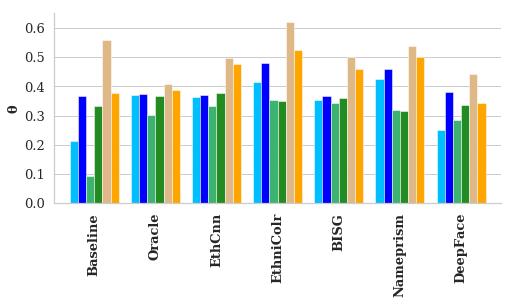

In [89]:
df = pd.DataFrame(DTloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,3.5)




#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),logy = False,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")


for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)


plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')

plt.ylabel("θ",weight='bold',size=13)


# plt.ylabel("Population Skew")
plt.savefig('compas_DT.pdf', bbox_inches = 'tight')

print('\\begin{table}[H]')
print('\centering')
LL = DTBR
dft['DTBR'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrr}
\toprule
{} &  Black\_Male &  White\_Male &  Latino\_Male &  White\_Female &  Black\_Female &  Latino\_Female &      DIBR \\
\midrule
Baseline  &    0.314294 &    0.324632 &     0.284676 &      0.487827 &      0.173729 &       0.073191 &  0.150034 \\
Oracle    &    0.334369 &    0.291903 &     0.282491 &      0.270766 &      0.271961 &       0.166037 &  0.496569 \\
EthCnn    &    0.311970 &    0.423545 &     0.274091 &      0.377808 &      0.234040 &       0.186148 &  0.439499 \\
EthniColr &    0.311814 &    0.196970 &     0.217381 &      0.271737 &      0.203934 &       0.208851 &  0.631690 \\
BISG      &    0.314716 &    0.408306 &     0.270215 &      0.382681 &      0.233885 &       0.206071 &  0.504697 \\
Nameprism &    0.284102 &    0.274905 &     0.202045 &      0.327184 &      0.184841 &       0.164303 &  0.502172 \\
DeepFace  &    0.325627 &    0.278434 &     0.272377 &      0.344317 &      0.191131 &       0.214222 &  0.555

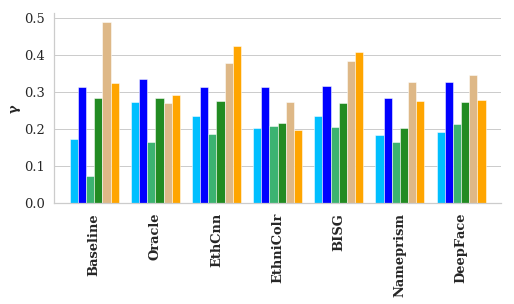

In [90]:
df = pd.DataFrame(DIloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (8,3.5)




#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),logy= False,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')

ax.get_legend().remove()
ax.xaxis.grid(False)
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)

# ax.yaxis.set_minor_formatter(ScalarFormatter())
# ax.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.grid(True,which='both')

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")


for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)


plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')

plt.ylabel("γ",weight='bold',size=13)



# ax.get_legend().remove()
# ax.xaxis.grid(False)
# ax.yaxis.grid(True,which='both')
# ax.yaxis.set_minor_formatter(ScalarFormatter())
# ax.yaxis.set_major_formatter(ScalarFormatter())

# #plt.legend(loc=(1.04,0))
# # plt.xlabel("Inference Algorithm")
# plt.xlabel(None)


# plt.yscale('log', basey=10)

# plt.ylabel("Population Skew")
plt.savefig('compas_DI.pdf', bbox_inches = 'tight')



print('\\begin{table}[H]')
print('\centering')
LL = DIBR
dft['DIBR'] = LL.values()
print(dft.drop(['X'], axis=1).to_latex())
print('\end{table}')

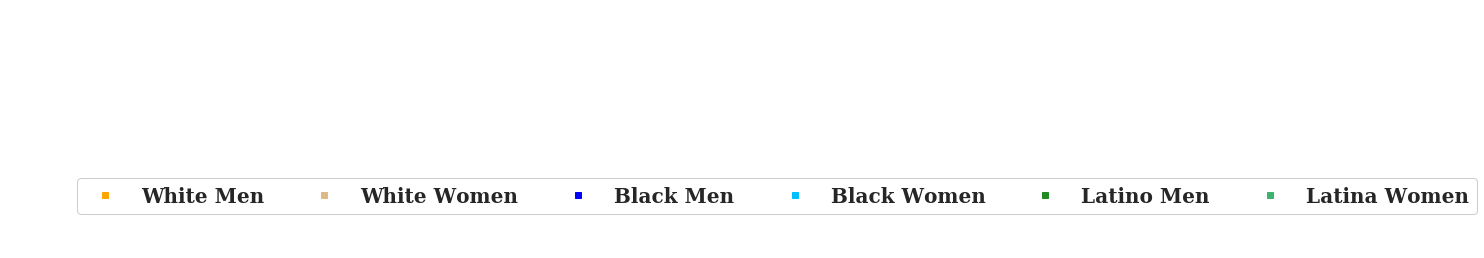

In [98]:
colors = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen']#, 'deeppink','orchid']
cats = ['White Men', 'White Women', 'Black Men', 'Black Women', 'Latino Men', 'Latina Women']#, 'Asian Male', 'Asian Female']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(colors))]
labels = cats
legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                    frameon=True,ncol=len(colors),facecolor='white', prop = {'weight':'bold', 'size': 20})
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')


def export_legend(legend, filename="compas_legend.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [92]:
# df = pd.DataFrame(geoattdloop_comp).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index

# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.alpha'] = 1
# plt.rcParams['grid.color'] = "#cccccc"
# plt.rcParams['axes.edgecolor'] = "#cccccc"



# #plt.grid(True)

# ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
# ax.set_facecolor('white')
# ax.get_legend().remove()
# ax.xaxis.grid(False)
# ax.yaxis.grid(True,which='both')

# #plt.legend(loc=(1.04,0))
# # plt.xlabel("Inference Algorithm")
# plt.xlabel(None)




# # plt.ylabel("Population Skew")
# plt.savefig('compas_geoattd.svg', bbox_inches = 'tight')

In [93]:
# attdloop_comp

In [94]:
# for method_name, rankedlist in zip(method_names, rankedlists):
#     attd = get_attention(rankedlist[:K],dist="geometric", p=0.1)
#     vals = attd.values()
#     print(method_name, attd)
#     print("Exposure bias ratio: ", min(vals)/max(vals))

In [95]:
# df = pd.DataFrame(geoattdloop).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index

# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.alpha'] = 1
# plt.rcParams['grid.color'] = "#cccccc"
# plt.rcParams['axes.edgecolor'] = "#cccccc"



# #plt.grid(True)

# ax = dft.plot(x="X", y=sorted(list(dftcol)),logy=True,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
# ax.set_facecolor('white')
# ax.get_legend().remove()
# ax.xaxis.grid(False)
# ax.yaxis.grid(True,which='both')

# #plt.legend(loc=(1.04,0))
# # plt.xlabel("Inference Algorithm")
# plt.xlabel(None)




# # plt.ylabel("Population Skew")
# plt.savefig('compas_geoattd.svg', bbox_inches = 'tight')

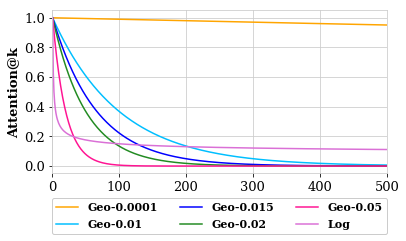

In [10]:
import math, numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from matplotlib.ticker import ScalarFormatter
geo_df = {}
geo_df['rank']=[]
geo_df['value']=[]
geo_df['type'] = []


plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["font.family"] = 'DejaVu Serif'

prob_vals = [0.0001, 0.01, 0.015, 0.02, 0.05, 'log']

for p in prob_vals:
    for i in range(1,1000):
        if p!='log':
            init_val = 1/p
            geo_att_i = init_val*((1-p)**(i-1))*p    
            geo_df['rank'].append(i)
            geo_df['value'].append(geo_att_i)
            geo_df['type'].append('geo-'+str(p))
        else:
            log_att_i = 1/(math.log2(1+i))
            geo_df['rank'].append(i)
            geo_df['value'].append(log_att_i)
            geo_df['type'].append('log')

geo_df = pd.DataFrame(geo_df)
# 'mediumseagreen'
color_list2 = ['orange', 'deepskyblue', 'blue', 'forestgreen', 'deeppink','orchid']

sns.lineplot(data= geo_df, x= 'rank', y='value', hue='type', palette=color_list2)

# ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')
ax = plt.gca()
ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim([0,500])

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)


plt.ylabel('Attention@k',fontsize=13,weight='bold')
plt.xlabel('Rank (k)', fontsize =13,weight='bold')


legend_list = ['Geo-'+str(i) if i!='log' else 'Log'  for i in prob_vals]
plt.legend(legend_list,
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.37,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3,
           prop={'size': 11, 'weight':'bold'})
# plt.savefig('geometric_log_ratio.pdf', bbox_inches='tight')

# X= [i for i in range(1,500)]
# ylog = logarithmic_attn_scores
# ygeo = geometric_attn_scores

# # plt.plot(X,ylog, label ='log')
# plt.plot(X,ygeo, label='geo')
# plt.legend()
# plt.show()
    